In [1]:
"""
n-gramのneural language modelで学習と予測を行うプログラム
"""

import torch
import torch.nn as nn
import torch.optim as optim


class NLM(nn.Module):
    """
    n-gram neural language model
    """

    def __init__(self, context_size, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear_W = nn.Linear(context_size*embedding_dim, hidden_dim)
        self.linear_U = nn.Linear(hidden_dim, vocab_size, bias=False)

    def forward(self, context_word_ids):
        batch_size = len(context_word_ids)
        # shape: (batch_size, context_size*embedding_dim)
        projection_layer = self.embedding(context_word_ids).view(batch_size, -1)
        # shape: (batch_size, hidden_dim)
        hidden_layer = torch.relu(self.linear_W(projection_layer))
        # shape: (batch_size, vocab_size)
        output_layer = self.linear_U(hidden_layer)
        # shape: (batch_size, vocab_size)
        return torch.log_softmax(output_layer, dim=1)


def build_vocab(sentences):
    all_tokens = []
    for s in sentences:
        all_tokens += s.split()
    vocab = set(all_tokens)
    token_to_index = dict(zip(vocab, range(len(vocab))))
    index_to_token = {index: token for token, index in token_to_index.items()}
    return token_to_index, index_to_token


def get_ngram_data(context_size, sentences, token_to_index):
    contexts, targets = [], []
    for s in sentences:
        tokens = s.split()
        for i in range(len(tokens)):
            if i+context_size == len(tokens):
                break
            context, target = tokens[i:i+context_size], tokens[i+context_size]
            context = torch.tensor(
                [token_to_index[w] for w in context], dtype=torch.long)
            target = torch.tensor(
                [token_to_index[target]], dtype=torch.long)
            contexts.append(context)
            targets.append(target)
    return torch.stack(contexts), torch.stack(targets)

In [2]:
sentences = []
with open('neko.txt.mecab', 'r') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        sentences.append(line)

In [3]:
ngram_size = 4
context_size = ngram_size - 1
sentences = [s for s in sentences if len(s.split()) >= ngram_size]
sentences = sentences[:1000]
token_to_index, index_to_token = build_vocab(sentences)
contexts, targets = get_ngram_data(context_size, sentences, token_to_index)

print(contexts[0])
print(targets[0])

tensor([  61, 3522, 1092])
tensor([2464])


In [4]:
import numpy as np
from tqdm import tqdm_notebook
model = NLM(
    context_size=context_size, vocab_size=len(token_to_index),
    embedding_dim=32, hidden_dim=32)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 20
batch_size =32

# training
losses = []
for _ in tqdm_notebook(range(num_epochs)):
    epoch_loss = 0.
    # batch Adam
    for _ in range(int(len(contexts) / batch_size)):
        r = np.random.randint(len(contexts), size=batch_size)
        context = contexts[r]
        target = targets[r]
        optimizer.zero_grad()
        log_prob = model(context)
        loss = criterion(log_prob, target.view(-1))
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    print(epoch_loss.item())
    losses.append(epoch_loss)

3993.388671875
3588.400390625
3303.180419921875
3099.498779296875
2952.833740234375
2809.509765625
2702.76806640625
2601.688232421875
2537.7666015625
2478.9130859375
2458.265380859375
2358.234375
2366.415771484375
2328.14306640625
2285.31298828125
2305.799072265625
2311.212890625
2298.869140625
2288.45703125
2243.047119140625



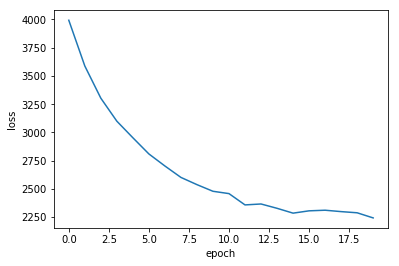

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses)

In [6]:
# predict
def predict(context_words):
    assert len(context_words) == context_size
    predicted_tokens = context_words.copy()
    while True:
        context_tensor = torch.tensor([token_to_index[w] for w in context_words])
        predicted_log_prob = model(context_tensor.view(1, -1))
        next_word_index = torch.argmax(predicted_log_prob).item()
        next_word = index_to_token[next_word_index]
        predicted_tokens.append(next_word)
        if next_word == '。':
            break
        context_words.pop(0)
        context_words.append(next_word)

    print(' '.join(predicted_tokens))
    
predict(['吾輩', 'は', '猫'])
predict(['名前', 'は', 'まだ'])
predict(['どこ', 'で', '生れ'])
predict(['何', 'でも', '薄暗い'])
predict(['吾輩', 'は', 'ここ'])
predict(['しかも', 'あと', 'で'])

吾輩 は 猫 より 申 すぐ し て いる 。
名前 は まだ ない 。
どこ で 生れ て 、 毛 の よう に なっ て いる の 画 を すぐ で ある 。
何 でも 薄暗い 供 。
吾輩 は ここ の よう に なっ て いる の 画 を すぐ で ある 。
しかも あと で ある 。
